# Notebook 3: Multifactor Risk Model Estimation

### **Objective**
The primary objective of this notebook is to construct a **multifactor risk model** from our historical data. This model is the quantitative engine that allows us to understand and decompose portfolio risk into its fundamental, economic drivers. Following the Grinold-Kahn framework, I will estimate the two core components of the risk model: the **Factor Covariance Matrix ($F$)** and the **Specific Risk Matrix ($\Delta$)**.

The final output is a forward-looking forecast of the total covariance matrix, $V$, built according to the fundamental equation of structural risk models:
$$ V = XFX^T + \Delta $$

---

### **Methodology & Pipeline**

We implement the classic **Fama-MacBeth two-step procedure** to estimate the risk model components from our historical time series of stock returns ($r$) and our point-in-time factor exposures ($X$).

*   **1. Cross-Sectional Regressions (First Pass):** We iterate through each month ($t$) in our historical sample. For each month, we run a single, large cross-sectional regression of all stock returns for that month against their known factor exposures from the beginning of the month.
    $$ r(t) = X(t)b(t) + u(t) $$
    *   The estimated coefficients, $\hat{b}(t)$, are the **factor returns** for that month.
    *   The regression residuals, $\hat{u}(t)$, are the **specific returns** for each stock in that month.
    This step produces a complete time series of historical factor returns and specific returns.

*   **2. Estimate the Factor Covariance Matrix ($F$):** Using the time series of the $K$ factor returns, $\hat{b}(t)$, we calculate their $K \times K$ sample covariance matrix. This matrix captures the volatility of the factors and, crucially, how they tend to move together.
    $$ F = \text{Cov}(\hat{b}) $$

*   **3. Estimate the Specific Risk Matrix ($\Delta$):** Using the time series of the $N$ specific returns, $\hat{u}(t)$, we calculate the variance of the specific returns for each individual stock. These variances become the diagonal elements of the $\Delta$ matrix. Following the model's core assumption, all off-diagonal elements (specific covariances) are set to zero.
    $$ \Delta_{nn} = \text{Var}(\hat{u}_n) $$

*   **4. Synthesize and Decompose:** We assemble the final covariance matrix $V$ and perform a sample risk decomposition to verify the model. We can show how a single stock's total risk is partitioned between the part explained by common factors and its unique specific risk.

---

### **Key Concepts & Theoretical Justification**

#### **1. The Multifactor Risk Model**

This model is a powerful simplification of the real world. It posits that the total covariance matrix ($V$) can be explained by two components:
*   **Systematic (Factor) Risk ($XFX^T$):** The risk arising from shared exposures ($X$) to common, correlated economic factors ($F$). This is the "macro blueprint" of risk.
*   **Specific (Idiosyncratic) Risk ($\Delta$):** The risk that is unique to each individual company, assumed to be uncorrelated across stocks.

This structure reduces a massive estimation problem (millions of covariances) to a much smaller, more stable, and economically intuitive problem.

#### **2. Fama-MacBeth Procedure**

This is the standard econometric technique for estimating a factor model's parameters from panel data (data with both a cross-sectional and a time-series dimension). By running a regression for each time period, it generates the time series of factor returns that are the essential input for estimating the factor covariance matrix, $F$.

#### **3. Risk Decomposition**

The ultimate practical use of this model is decomposition. For any given stock $n$, we can decompose its total variance, $\sigma_n^2$, into its two orthogonal components:
$$ \sigma_n^2 = \sigma_{n, \text{factor}}^2 + \sigma_{n, \text{specific}}^2 $$
Where:
*   The **factor variance** is given by $\sigma_{n, \text{factor}}^2 = X_n F X_n^T$. ($X_n$ is the row vector of exposures for stock $n$).
*   The **specific variance** is given by $\sigma_{n, \text{specific}}^2 = \Delta_{nn}$.

This allows a portfolio manager to understand the true sources of risk for any asset in their portfolio.

---
**Output:** This notebook produces the core components of our risk model: the estimated Factor Covariance Matrix (`F`) and the vector of Specific Variances (the diagonal of $\Delta$). These are essential inputs for the portfolio construction and optimization process in Notebook 5.



In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm # The library for running regressions
import os
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully.")

Libraries imported successfully.


In [21]:
# --- Load the processed data from previous notebooks ---
DATA_DIR = 'data'
RETURNS_FILE = os.path.join(DATA_DIR, 'monthly_excess_returns.csv')
EXPOSURES_FILE = os.path.join(DATA_DIR, 'factor_exposures.csv')

# Load the data
monthly_excess_returns = pd.read_csv(RETURNS_FILE, index_col='Date', parse_dates=True)
# For this illustrative notebook, I'll assume our factor exposures are constant for simplicity.
# A real model would have a different X matrix for each month.
X = pd.read_csv(EXPOSURES_FILE, index_col=0)

# Align the data: Ensure we only use dates and stocks present in both files.
common_dates = monthly_excess_returns.index
common_stocks = X.index
monthly_excess_returns = monthly_excess_returns.loc[common_dates, common_stocks]

print("Data from Notebooks 1 & 2 loaded successfully.")
print("\nFactor Exposures (X):")
print(X.head())
print("\nMonthly Excess Returns (r):")
print(monthly_excess_returns.head())

Data from Notebooks 1 & 2 loaded successfully.

Factor Exposures (X):
           Size     Value  Momentum
AAPL   0.673549 -0.791782 -0.229023
AMZN   0.072566  0.292714  0.913754
GOOGL  0.461882 -0.475909 -0.093175
JNJ   -2.439123  0.588061 -2.641663
JPM   -1.547600  2.597559 -1.382237

Monthly Excess Returns (r):
                AAPL      AMZN     GOOGL       JNJ       JPM      MSFT  \
Date                                                                     
2019-02-28  0.042977 -0.047706 -0.001214  0.031760  0.006509  0.075558   
2019-03-31  0.095126  0.084036  0.042785  0.021153 -0.031892  0.050854   
2019-04-30  0.054336  0.079759  0.016653  0.007987  0.153071  0.105243   
2019-05-31 -0.126313 -0.080713 -0.079217 -0.066920 -0.089045 -0.051581   
2019-06-30  0.128719  0.064992 -0.023219  0.060190  0.053316  0.081318   

                  PG      TSLA       UNH       XOM  
Date                                                
2019-02-28  0.019761  0.040086 -0.105353  0.088640  
2019-03

In [22]:
# --- Run Fama-MacBeth Cross-Sectional Regressions ---

# I'll store the results (factor returns and residuals) in lists
factor_returns_list = []
residuals_list = []

# Add a constant to the exposure matrix (necessary for statsmodels).
# This acts as the regression intercept.
X_with_const = sm.add_constant(X)

# Loop through each month in our returns data
for date, returns_for_month in monthly_excess_returns.iterrows():
    # 'returns_for_month' is a Series of N stock returns for a single date (our Y variable)
    # 'X_with_const' is our N x K matrix of factor exposures (our X variables)
    
    # Drop any stocks with missing returns for this specific month
    returns_for_month.dropna(inplace=True)
    X_aligned = X_with_const.reindex(returns_for_month.index)
    
    # Run the cross-sectional regression for this month
    # We use OLS for simplicity. A real model would use GLS.
    model = sm.OLS(returns_for_month, X_aligned)
    results = model.fit()
    
    # Store the estimated coefficients (the factor returns, 'b')
    factor_returns_list.append(results.params)
    
    # Store the residuals (the specific returns, 'u')
    residuals_list.append(results.resid)

# Convert the lists of results into DataFrames
factor_returns = pd.DataFrame(factor_returns_list, index=monthly_excess_returns.index)
specific_returns = pd.DataFrame(residuals_list, index=monthly_excess_returns.index)

print("Fama-MacBeth regressions complete.")
print("\nTime Series of Factor Returns (b):")
print(factor_returns.head())
print("\nTime Series of Specific Returns (u):")
print(specific_returns.head())


Fama-MacBeth regressions complete.

Time Series of Factor Returns (b):
               const      Size     Value  Momentum
Date                                              
2019-02-28  0.026356  0.021740  0.004423 -0.012659
2019-03-31  0.040438  0.039983 -0.010946 -0.046747
2019-04-30  0.046167  0.064218  0.018534 -0.044708
2019-05-31 -0.099272  0.003309 -0.007036 -0.032641
2019-06-30  0.077209 -0.020872 -0.001836  0.034288

Time Series of Specific Returns (u):
                AAPL      AMZN     GOOGL       JNJ       JPM      MSFT  \
Date                                                                     
2019-02-28  0.002581 -0.065367 -0.036686  0.022391 -0.015188  0.040958   
2019-03-31  0.008384  0.086615 -0.025685 -0.038814 -0.046635  0.000520   
2019-04-30 -0.030649  0.064358 -0.054521 -0.010547  0.096347  0.037386   
2019-05-31 -0.042315  0.050204  0.012138 -0.041667 -0.011495  0.054873   
2019-06-30  0.071967 -0.041496 -0.088466  0.023728 -0.004033  0.005663   

               

Factor Covariance Matrix (F) (Annualized):
              Size     Value  Momentum
Size      0.015830  0.004648 -0.020145
Value     0.004648  0.007125 -0.002483
Momentum -0.020145 -0.002483  0.036023


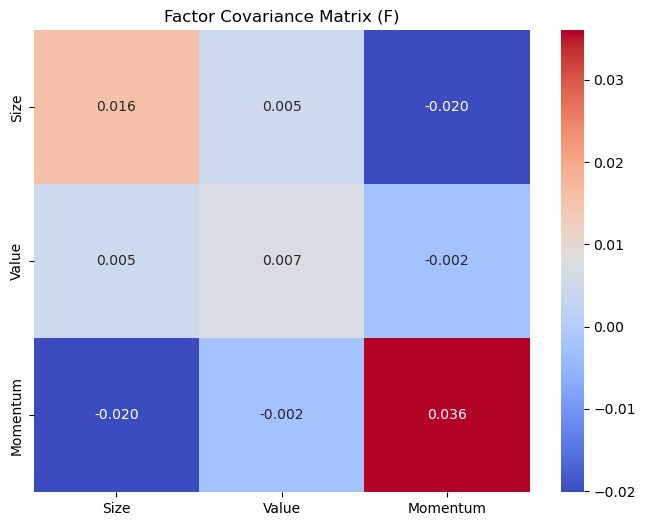

In [23]:
# --- Calculate the Factor Covariance Matrix (F) ---

# First, we must remove the 'const' column from our factor returns.
# The intercept is a statistical artifact of the regression for each period,
# not a persistent economic risk factor.
factor_returns_no_const = factor_returns.drop(columns='const')

# Now, calculate the covariance of the actual factors.
# We multiply by 12 to annualize the covariance from monthly data.
F = factor_returns_no_const.cov() * 12

print("Factor Covariance Matrix (F) (Annualized):")
print(F)

# For better visualization, let's plot a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(F, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Factor Covariance Matrix (F)')
plt.show()


In [24]:
# --- Calculate the Specific Risk Matrix (Delta) ---

# The specific variance for each stock is the variance of its specific return time series.
# We multiply by 12 to annualize the variance from monthly data.
specific_variances = specific_returns.var() * 12

# The Delta matrix is a diagonal matrix with these variances on the diagonal.
Delta = np.diag(specific_variances)

# Let's just look at the specific variances themselves (the diagonal of Delta)
print("Annualized Specific Variances (Diagonal of Delta):")
print(specific_variances)


Annualized Specific Variances (Diagonal of Delta):
AAPL     0.025802
AMZN     0.050401
GOOGL    0.023028
JNJ      0.017107
JPM      0.024690
MSFT     0.020053
PG       0.020776
TSLA     0.032015
UNH      0.030182
XOM      0.024925
dtype: float64


In [25]:
# --- Reconstruct the Total Covariance Matrix (V) ---
# V = X * F * X^T + Delta

# Let's calculate the systematic component first
X_no_const = X # Use the original X without the constant for this part
systematic_cov = X_no_const @ F @ X_no_const.T 

# Now, add the specific risk component
# Note: np.diag() extracts the diagonal, then we create a diagonal matrix from it.
# This ensures Delta has the same index/columns as our systematic_cov matrix.
V_model = systematic_cov + pd.DataFrame(np.diag(specific_variances), 
                                         index=X_no_const.index, 
                                         columns=X_no_const.index)

print("Model-Based Total Covariance Matrix (V) successfully constructed.")

# --- Sanity Check: Compare Model Risk vs. Historical Risk for a stock ---
# Let's pick a stock, e.g., Apple
ticker_to_check = 'AAPL'

# Model-based total variance is the diagonal element of V
model_variance = V_model.loc[ticker_to_check, ticker_to_check]
model_risk = np.sqrt(model_variance)

# Simple historical variance
historical_variance = monthly_excess_returns[ticker_to_check].var() * 12
historical_risk = np.sqrt(historical_variance)

print(f"\n--- Risk Analysis for {ticker_to_check} ---")
print(f"Model-Based Total Risk (Annualized): {model_risk:.2%}")
print(f"Simple Historical Risk (Annualized): {historical_risk:.2%}")

# Let's also decompose the model risk
factor_risk_sq = systematic_cov.loc[ticker_to_check, ticker_to_check]
specific_risk_sq = specific_variances[ticker_to_check]
print(f"  - Attributable to Factors: {np.sqrt(factor_risk_sq):.2%}")
print(f"  - Attributable to Specific Risk: {np.sqrt(specific_risk_sq):.2%}")
print(f"  - % of Variance from Factors: {factor_risk_sq / model_variance:.2%}")


Model-Based Total Covariance Matrix (V) successfully constructed.

--- Risk Analysis for AAPL ---
Model-Based Total Risk (Annualized): 19.92%
Simple Historical Risk (Annualized): 30.12%
  - Attributable to Factors: 11.79%
  - Attributable to Specific Risk: 16.06%
  - % of Variance from Factors: 35.00%


In [27]:
# At the end of Notebook 3
factor_returns.to_csv('data/factor_returns.csv')
specific_returns.to_csv('data/specific_returns.csv')
